In [ ]:
import os
import zipfile
import torch
import torchvision
import numpy as np
from PIL import Image
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.segmentation import deeplabv3_resnet101
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {device}")

🔧 Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/train_backup.zip"
extract_path = "/content/data/"
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, split='train', val_split=0.2):
        super().__init__()
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.split = split

        # ✅ Get image and mask filenames
        self.images = sorted(os.listdir(self.img_dir))
        self.masks = sorted(os.listdir(self.mask_dir))

        # ✅ Split dataset
        total = len(self.images)
        val_size = int(total * val_split)
        if split == 'train':
            self.images = self.images[:-val_size]
            self.masks = self.masks[:-val_size]
        else:
            self.images = self.images[-val_size:]
            self.masks = self.masks[-val_size:]

        # ✅ Detect number of classes
        self.max_class = 0
        for mask_file in self.masks[:1000]:
            mask = np.array(Image.open(os.path.join(self.mask_dir, mask_file)))
            self.max_class = max(self.max_class, mask.max())
        self.num_classes = self.max_class + 1

        print(f"[INFO] Loaded {len(self.images)} '{split}' samples")
        print(f"[INFO] Detected number of classes: {self.num_classes}")

        # ✅ Image normalization (ImageNet stats)
        self.img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # ✅ Load and transform image
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        image = self.img_transform(image)
        mask = torch.from_numpy(np.array(mask)).long()

        # ✅ Validate mask values
        if mask.max() >= self.num_classes:
            raise ValueError(
                f"[ERROR] Invalid class label {mask.max()} in mask {self.masks[idx]} — max allowed: {self.num_classes - 1}"
            )

        return image, mask

In [ ]:
img_dir = os.path.join(extract_path, "images")
mask_dir = os.path.join(extract_path, "masks")
dataset = SegmentationDataset(img_dir, mask_dir)
num_classes = dataset.num_classes

[INFO] Loaded 75704 'train' samples
[INFO] Detected number of classes: 81


In [ ]:
train_size = int(0.80 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2, pin_memory=True, prefetch_factor=4, persistent_workers=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=2, pin_memory=True, prefetch_factor=4, persistent_workers=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = deeplabv3_resnet101(pretrained=True, progress=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 89.1MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

In [ ]:
scaler = GradScaler()

/tmp/ipython-input-10-4292142752.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
import os
import torch
import shutil
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

checkpoint_dir = "/content/drive/MyDrive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
def compute_iou(pred, target, num_classes):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return torch.tensor(ious).nanmean().item()

def compute_pixel_accuracy(pred, target):
    correct = (pred == target).float()
    return correct.sum() / correct.numel()


In [ ]:
def find_latest_checkpoint():
    if not os.path.exists(checkpoint_dir):
        return None

    checkpoints = [
        f for f in os.listdir(checkpoint_dir)
        if f.startswith("epoch") and f.endswith(".pt")
    ]

    if not checkpoints:
        return None

    def extract_numbers(fname):
        parts = fname.replace("epoch_", "").replace(".pt", "").split("_batch_")
        return int(parts[0]), int(parts[1]) if len(parts) > 1 else 0

    checkpoints.sort(key=lambda x: extract_numbers(x), reverse=True)
    return os.path.join(checkpoint_dir, checkpoints[0])

latest_ckpt_path = find_latest_checkpoint()

In [ ]:
start_epoch = 0
start_batch = 0

scaler = GradScaler()

if latest_ckpt_path:
    print(f"🔁 Resuming from {latest_ckpt_path}")
    checkpoint = torch.load(latest_ckpt_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    scaler.load_state_dict(checkpoint["scaler_state_dict"])
    start_epoch = checkpoint["epoch"]
    start_batch = checkpoint.get("batch", 0)
else:
    print("🆕 Starting training from scratch")

/tmp/ipython-input-14-57686364.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


🔁 Resuming from /content/drive/MyDrive/checkpoints/epoch_36_batch_0.pt


In [ ]:
import os
import torch
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import time

# ✅ Directory for checkpoint
checkpoint_dir = "/content/drive/MyDrive/checkpoints"
assert os.path.exists(checkpoint_dir), "❌ Checkpoint directory does not exist."

In [ ]:
def find_latest_checkpoint():
    ckpts = [f for f in os.listdir(checkpoint_dir) if f.startswith("epoch_") and f.endswith(".pt")]
    if not ckpts:
        return None

    def extract_numbers(f):
        parts = f.replace("epoch_", "").replace(".pt", "").split("_batch_")
        return int(parts[0]), int(parts[1]) if len(parts) > 1 else 0

    ckpts.sort(key=lambda x: extract_numbers(x), reverse=True)
    return os.path.join(checkpoint_dir, ckpts[0])

In [ ]:
latest_ckpt = find_latest_checkpoint()
assert latest_ckpt, "❌ No checkpoint found to resume."

checkpoint = torch.load(latest_ckpt, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
scaler = GradScaler()
scaler.load_state_dict(checkpoint["scaler_state_dict"])

start_epoch = checkpoint["epoch"]
start_batch = checkpoint.get("batch", 0)
num_classes = checkpoint["num_classes"]

print(f"✅ Resuming from: {latest_ckpt}")
print(f"🔁 Epoch: {start_epoch}, Batch: {start_batch}")

✅ Resuming from: /content/drive/MyDrive/checkpoints/epoch_31_batch_1400.pt
🔁 Epoch: 31, Batch: 1400


/tmp/ipython-input-19-684367051.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
num_epochs = 3
save_every_batches = 3000
model.to(device)

for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} [Train]")

    for batch_idx, (images, masks) in pbar:
        if epoch == start_epoch and batch_idx < start_batch:
            continue

        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        pbar.set_postfix({"Batch Loss": loss.item()})

        if (batch_idx + 1) % save_every_batches == 0:
            temp_ckpt_path = os.path.join(checkpoint_dir, f"epoch_{epoch}_batch_{batch_idx+1}.pt")
            torch.save({
                "epoch": epoch,
                "batch": batch_idx + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
                "num_classes": num_classes
            }, temp_ckpt_path)
            print(f"💾 Saved intermediate checkpoint: {temp_ckpt_path}")

    scheduler.step()

    # -------------------------
    # ✅ Validation Phase
    # -------------------------
    model.eval()
    val_loss = 0.0
    iou_scores = []
    acc_scores = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]"):
            images = images.to(device)
            masks = masks.to(device)

            with autocast():
                outputs = model(images)["out"]
                loss = criterion(outputs, masks)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)

            iou_scores.append(compute_iou(preds, masks, num_classes))
            acc_scores.append(compute_pixel_accuracy(preds, masks).item())

    print(f"📊 Epoch {epoch+1} Summary:")
    print(f"   🧮 Training Loss   : {epoch_loss / len(train_loader):.4f}")
    print(f"   📉 Validation Loss : {val_loss / len(val_loader):.4f}")
    print(f"   📈 Mean IoU        : {sum(iou_scores)/len(iou_scores):.4f}")
    print(f"   🎯 Pixel Accuracy  : {sum(acc_scores)/len(acc_scores):.4f}")

    # -------------------------
    # ✅ Save Full Checkpoint
    # -------------------------
    full_ckpt_path = os.path.join(checkpoint_dir, f"epoch_{epoch+1}_batch_0.pt")
    torch.save({
        "epoch": epoch + 1,
        "batch": 0,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
        "val_loss": val_loss / len(val_loader),
        "val_iou": sum(iou_scores)/len(iou_scores),
        "val_acc": sum(acc_scores)/len(acc_scores),
        "num_classes": num_classes
    }, full_ckpt_path)
    print(f"✅ Saved full checkpoint: {full_ckpt_path}")

    # ✅ Delete previous checkpoints
    for fname in os.listdir(checkpoint_dir):
        if fname.startswith("epoch_") and fname != os.path.basename(full_ckpt_path):
            try:
                os.remove(os.path.join(checkpoint_dir, fname))
            except Exception as e:
                print(f"⚠️ Failed to delete {fname}: {e}")

    start_batch = 0

In [ ]:
num_epochs = 35
save_every_batches = 1400
model.to(device)

best_val_iou = 0.0
patience = 3
epochs_no_improve = 0

for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} [Train]")

    for batch_idx, (images, masks) in pbar:
        if epoch == start_epoch and batch_idx < start_batch:
            continue

        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast("cuda"):
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        pbar.set_postfix({"Batch Loss": loss.item()})

        if (batch_idx + 1) % save_every_batches == 0:
            temp_ckpt_path = os.path.join(checkpoint_dir, f"epoch_{epoch}_batch_{batch_idx+1}.pt")
            torch.save({
                "epoch": epoch,
                "batch": batch_idx + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
                "num_classes": num_classes
            }, temp_ckpt_path)
            print(f"💾 Saved intermediate checkpoint: {temp_ckpt_path}")


    # ✅ Validation
    model.eval()
    val_loss = 0.0
    iou_scores = []
    acc_scores = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]"):
            images = images.to(device)
            masks = masks.to(device)

            with torch.amp.autocast("cuda"):
                outputs = model(images)["out"]
                loss = criterion(outputs, masks)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            iou_scores.append(compute_iou(preds, masks, num_classes))
            acc_scores.append(compute_pixel_accuracy(preds, masks).item())

    mean_iou = sum(iou_scores) / len(iou_scores)
    mean_acc = sum(acc_scores) / len(acc_scores)

    print(f"📊 Epoch {epoch+1} Summary:")
    print(f"   🧮 Training Loss   : {epoch_loss / len(train_loader):.4f}")
    print(f"   📉 Validation Loss : {val_loss / len(val_loader):.4f}")
    print(f"   📈 Mean IoU        : {mean_iou:.4f}")
    print(f"   🎯 Pixel Accuracy  : {mean_acc:.4f}")

    scheduler.step(mean_iou)

    # ✅ Save Best Checkpoint
    if mean_iou > best_val_iou:
        best_val_iou = mean_iou
        best_ckpt_path = os.path.join(checkpoint_dir, f"best_iou.pt")
        torch.save({
            "epoch": epoch + 1,
            "batch": 0,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "scaler_state_dict": scaler.state_dict(),
            "val_loss": val_loss / len(val_loader),
            "val_iou": mean_iou,
            "val_acc": mean_acc,
            "num_classes": num_classes
        }, best_ckpt_path)
        print(f"🌟 Saved best checkpoint: {best_ckpt_path}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # ✅ Save Latest Checkpoint (only keep most recent)
    latest_ckpt_path = os.path.join(checkpoint_dir, f"epoch_{epoch+1}_batch_0.pt")
    if os.path.exists(latest_ckpt_path):
        os.remove(latest_ckpt_path)
    torch.save({
        "epoch": epoch + 1,
        "batch": 0,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
            "val_loss": val_loss / len(val_loader),
            "val_iou": mean_iou,
            "val_acc": mean_acc,
        "num_classes": num_classes
    }, latest_ckpt_path)
    print(f"💾 Saved latest checkpoint: {latest_ckpt_path}")


    # ✅ Early stopping check
    if epochs_no_improve >= patience:
        print("🛑 Early stopping triggered!")
        break

    start_batch = 0

In [ ]:
# ✅ Export Model for Inference
inference_path = "/content/drive/MyDrive/segmentation_model_final.pt"
torch.save(model.state_dict(), inference_path)
print(f"📦 Exported model weights to: {inference_path}")

📦 Exported model weights to: /content/drive/MyDrive/segmentation_model_final.pt


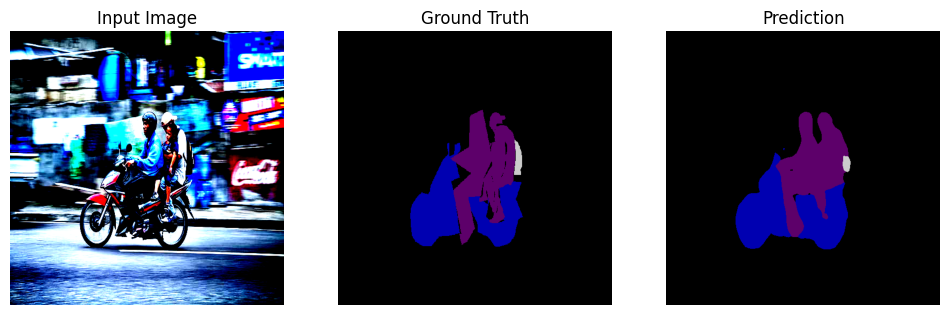

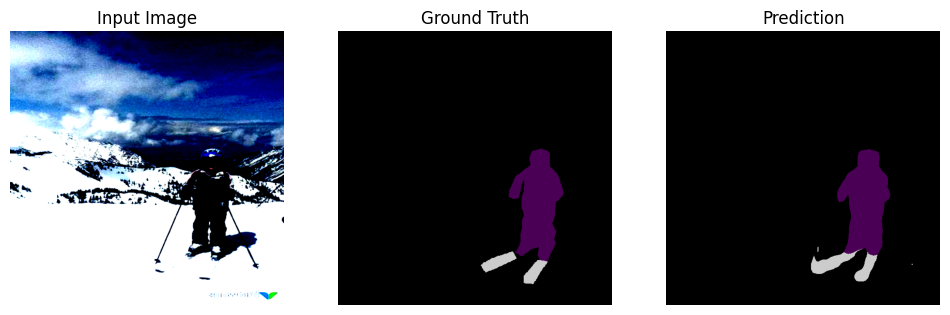

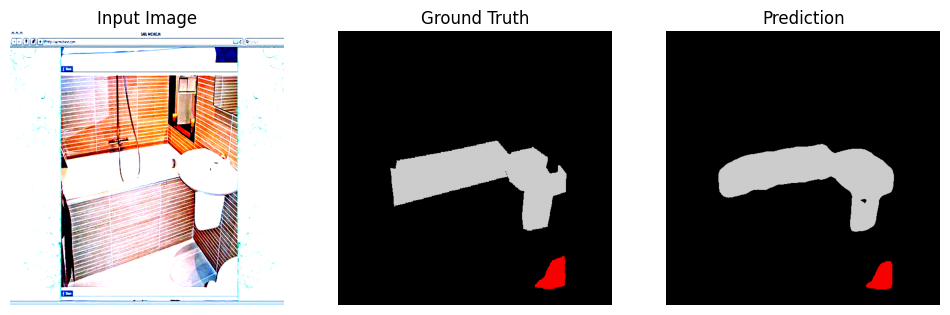

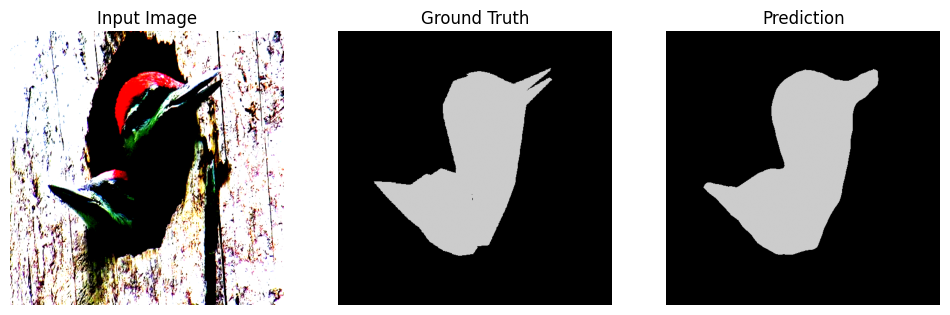

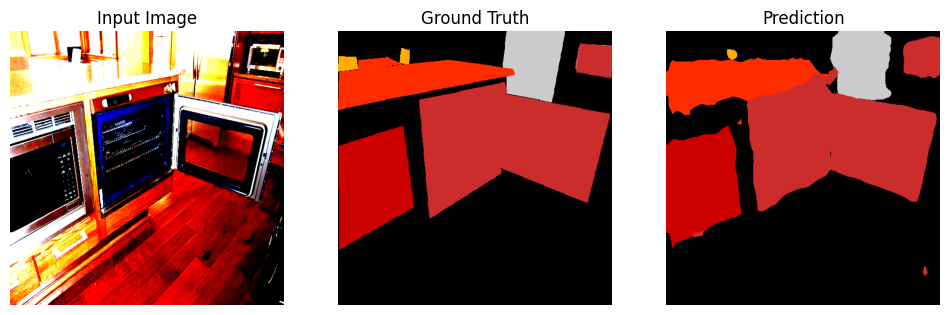

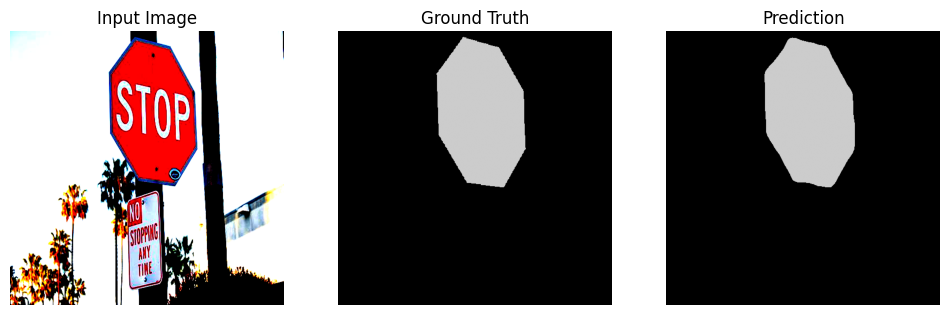

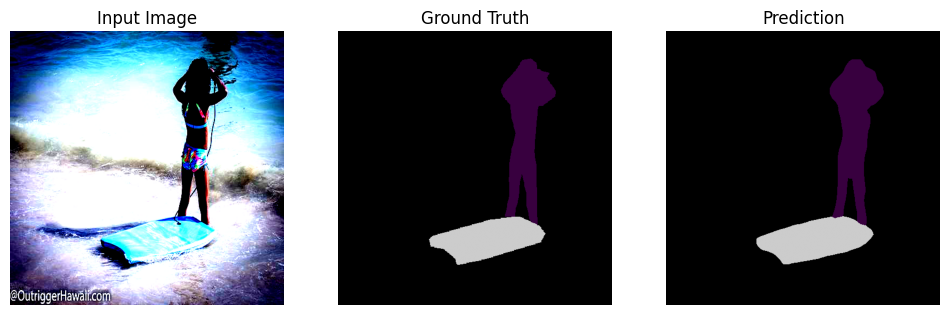

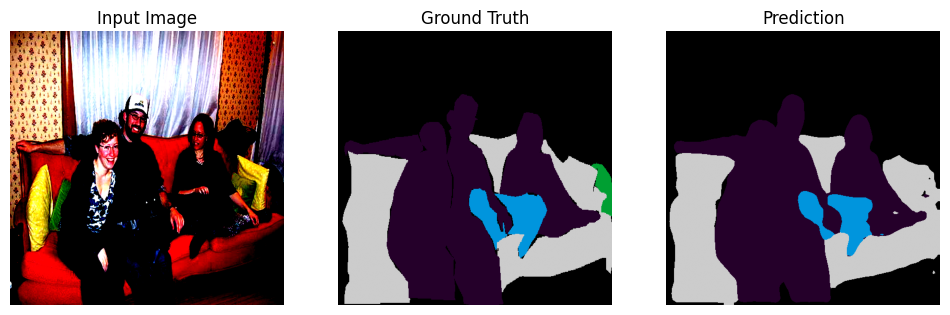

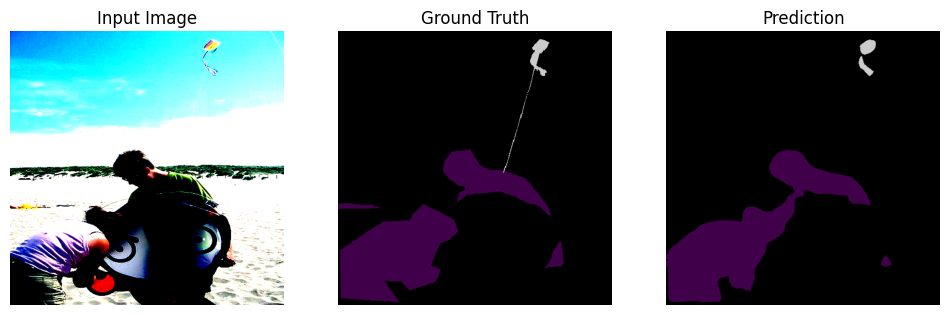

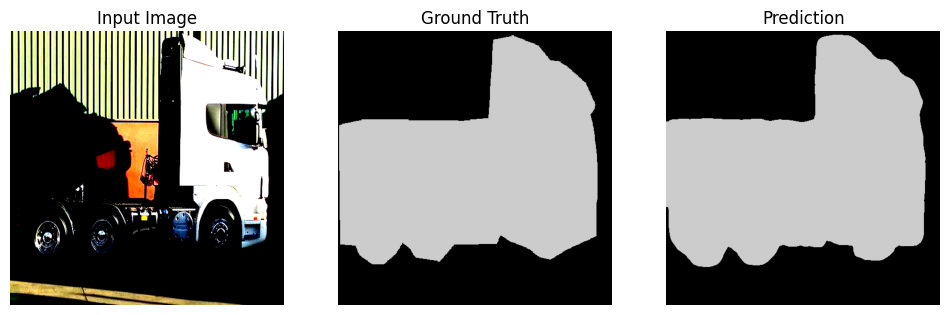

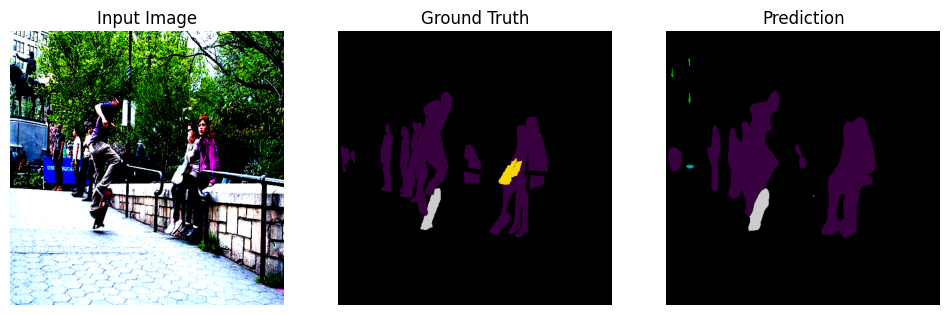

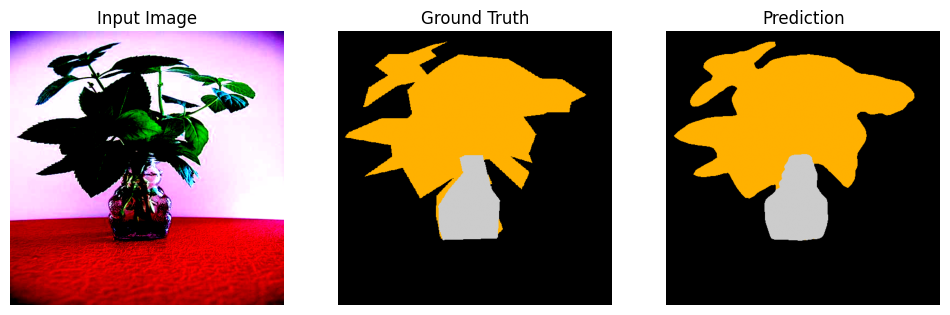

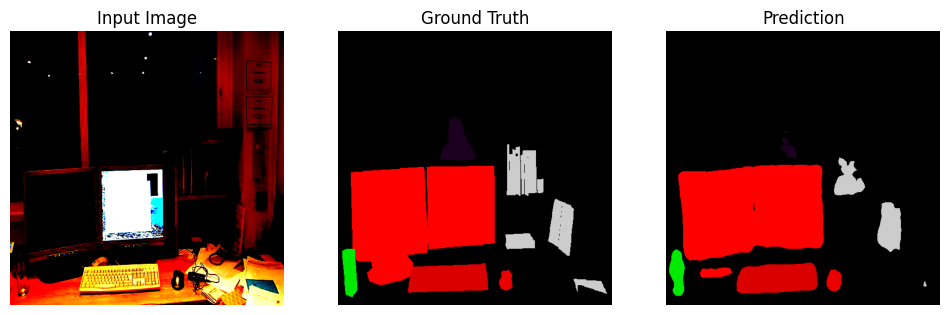

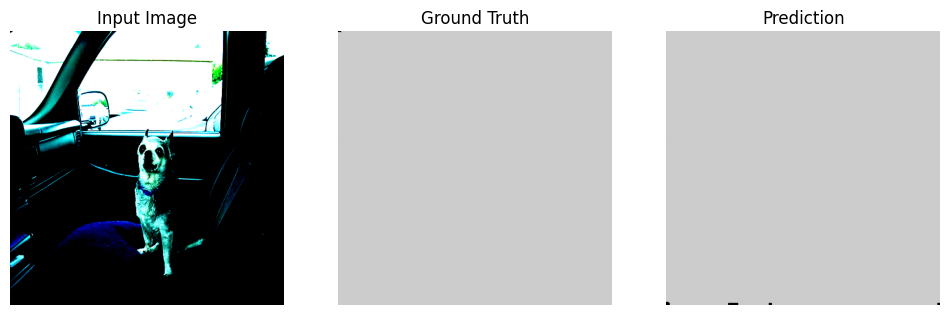

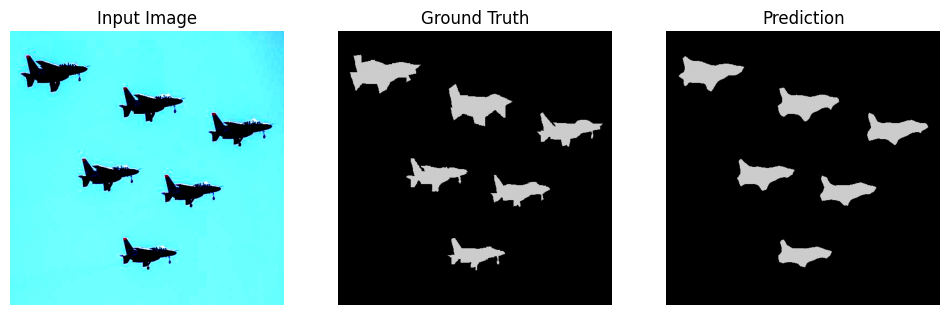

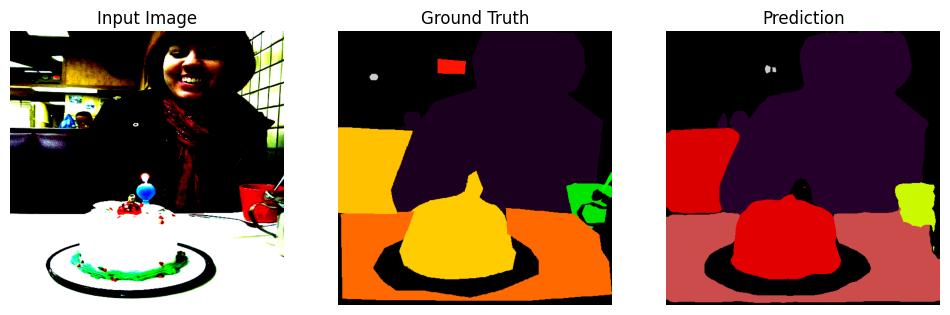

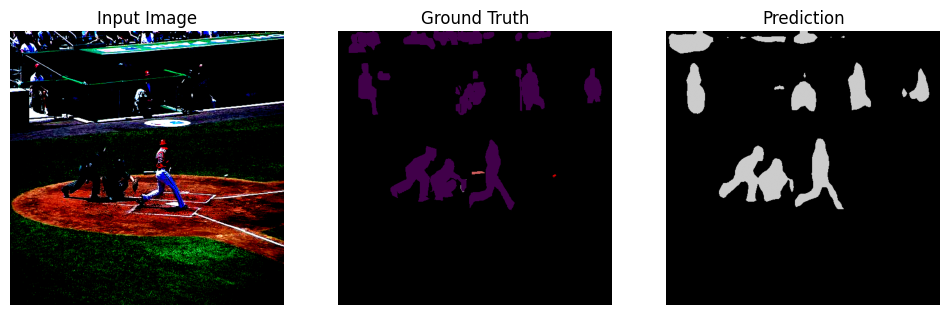

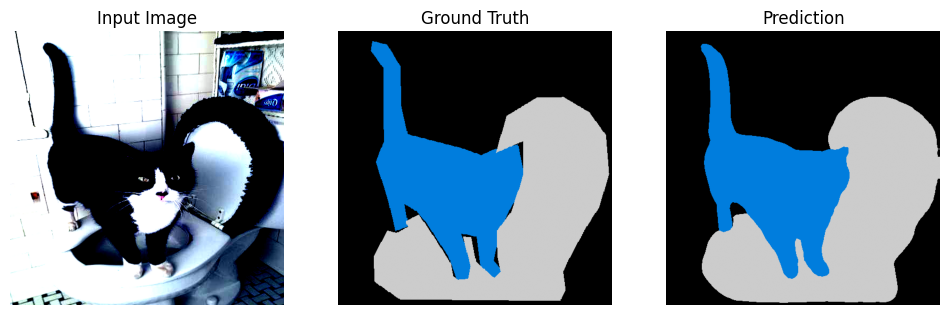

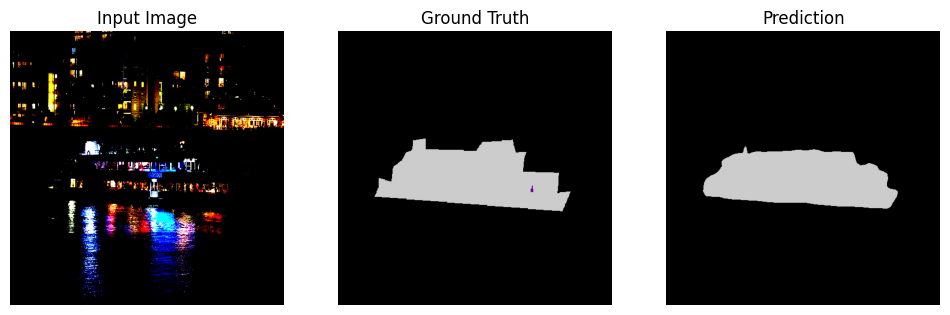

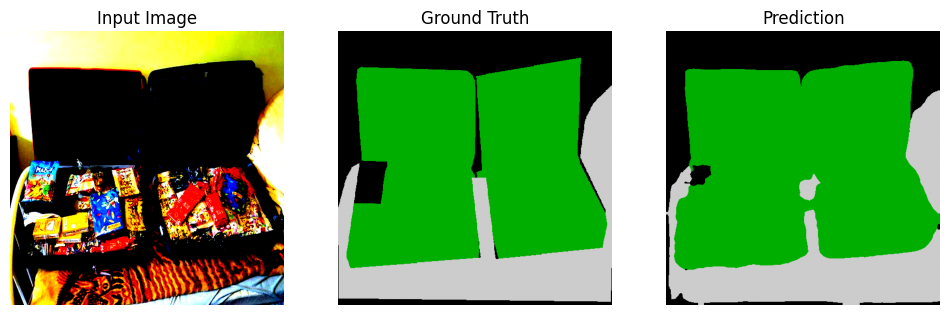

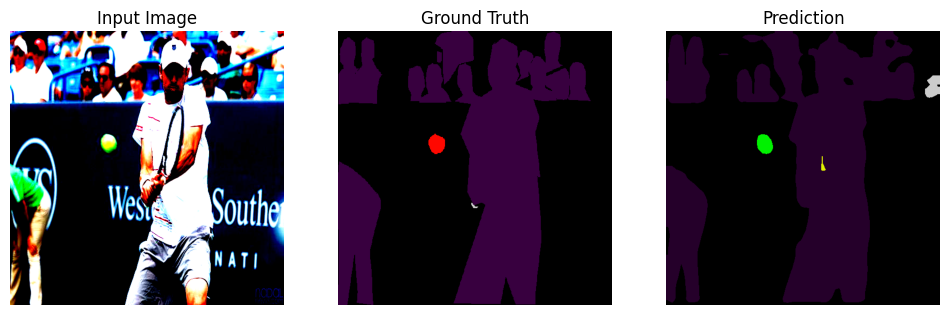

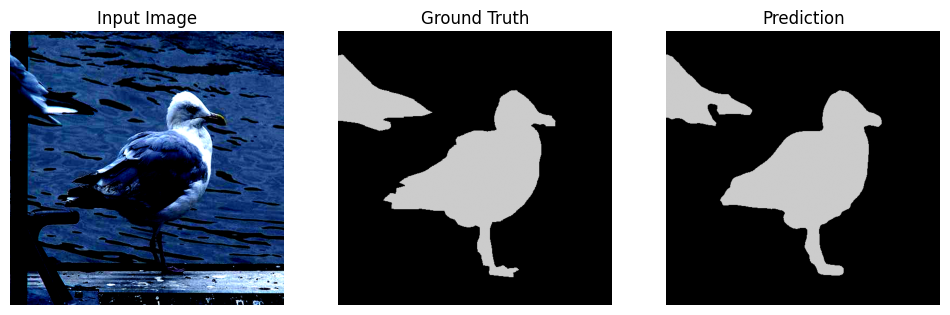

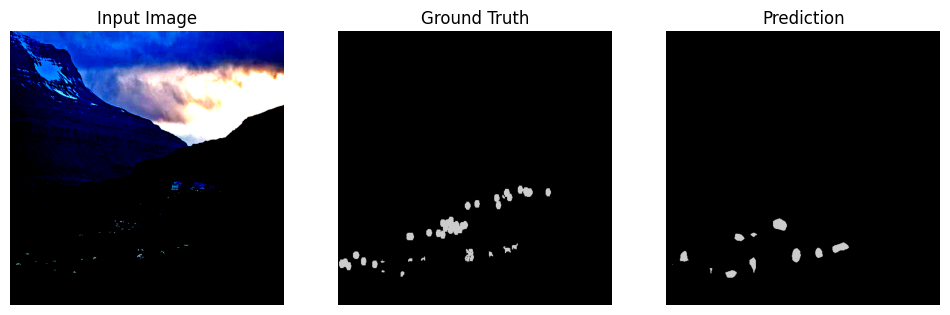

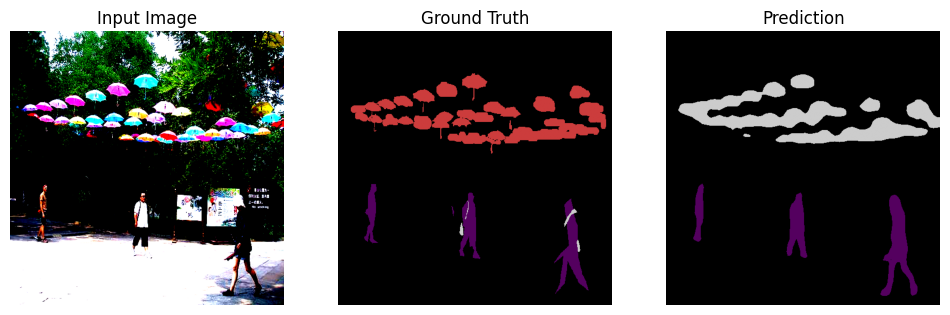

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
model.eval()
num_samples = 3

with torch.no_grad():
    for idx, (images, masks) in enumerate(val_loader):
        if idx >= num_samples:
            break
        images = images.to(device)
        outputs = model(images)["out"]
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        images = images.cpu().permute(0, 2, 3, 1).numpy()
        masks = masks.cpu().numpy()

        for i in range(images.shape[0]):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(masks[i], cmap="nipy_spectral")
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(preds[i], cmap="nipy_spectral")
            plt.title("Prediction")
            plt.axis("off")

            plt.show()


In [ ]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

# ✅ Load your best model (already trained)
checkpoint_path = "/content/drive/MyDrive/checkpoints/best_iou.pt"
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

class WrapperDeepLab(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.model = base_model

    def forward(self, x):
        return self.model(x)['out']  # Only return the 'out' tensor

# Load your trained model
model = deeplabv3_resnet101(weights=None, aux_loss=True)
model.classifier = DeepLabHead(2048, checkpoint["num_classes"])
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Wrap it
wrapped_model = WrapperDeepLab(model)

# Trace with dummy input
example_input = torch.randn(1, 3, 512, 512)
traced_model = torch.jit.trace(wrapped_model, example_input)

# Save TorchScript model
traced_model.save("deeplabv3_traced.pt")
print("✅ TorchScript model saved as 'deeplabv3_traced.pt'")


✅ TorchScript model saved as 'deeplabv3_traced.pt'


In [ ]:
inference_code = '''
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import sys

# ✅ Load TorchScript model
model = torch.jit.load("deeplabv3_traced.pt", map_location="cpu", weights_only=False)
model.eval()

# ✅ Standard ImageNet normalization
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to training size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def predict_mask(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # Shape: [1, 3, H, W]

    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.argmax(output.squeeze(0), dim=0).cpu().numpy()

    return pred_mask  # Shape: (512, 512) or resized shape, values = class indices

# Optional: CLI
if __name__ == "__main__":
    if len(sys.argv) < 2:
        print("❌ Usage: python inference.py <image_path>")
        sys.exit(1)

    image_path = sys.argv[1]
    mask = predict_mask(image_path)

    print("✅ Predicted mask shape:", mask.shape)
    print("   Unique classes:", np.unique(mask))
'''

# ✅ Save to file
with open("inference.py", "w") as f:
    f.write(inference_code)

print("✅ inference.py saved.")


✅ inference.py saved.


In [ ]:
import zipfile

zip_path = "/content/deeplabv3_inference.zip"

with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write("deeplabv3_traced.pt")
    zipf.write("inference.py")

print(f"✅ Created ZIP: {zip_path}")

✅ Created ZIP: /content/deeplabv3_inference.zip


In [ ]:
import os
drive_save_path = "/content/drive/MyDrive/SegmentationExports"
os.makedirs(drive_save_path, exist_ok=True)

# Copy zip to drive
!cp /content/deeplabv3_inference.zip "$drive_save_path"

print(f"✅ Saved to Google Drive: {drive_save_path}/deeplabv3_inference.zip")

✅ Saved to Google Drive: /content/drive/MyDrive/SegmentationExports/deeplabv3_inference.zip
